In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
import h5py
import seaborn as sns
from scipy.special import logit
from scipy.special import expit
from scipy.interpolate import RegularGridInterpolator
from pylab import rcParams
import sys
import torch
import scipy
import corner
import copy
from copy import deepcopy

import sys
sys.path.append('../')
from populations.bbh_models import read_hdf5
from populations.bbh_models import get_models
from populations.Flowsclass_dev import FlowModel
from populations.utils.bounded_Nd_kde import Bounded_Nd_kde
from populations import gw_obs
from sample import sample as samp


PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


glasflow is using its own internal version of nflows


In [3]:
#flags/inputs:
param = ['mchirp','q', 'chieff', 'z']
no_params = len(param)
channel_label = 'CE'

channel_ids = {'CE':0, 'CHE':1,'GC':2,'NSC':3, 'SMT':4}
channel_id = channel_ids[channel_label] #will be 0, 1, 2, 3, or 4
chi_b = [0.0,0.1,0.2,0.5]
alpha_CE = [0.2,0.5,1.0,2.,5.]
channel_samples = [4e6,864124,896611,582961, 4e6]
no_binaries = int(channel_samples[channel_id])
batch_size = 10000
total_hps=20

models_path ='/Users/stormcolloms/Documents/PhD/Project_work/OneChannel_Flows/models_reduced.hdf5'
#models_path ='/Users/stormcolloms/Documents/PhD/Project_work/AMAZE_model_selection/testing_notebooks/flow_samples.hdf5'
popsynth_outputs = read_hdf5(models_path, channel_label) # read all data from hdf5 file

models_dict = dict.fromkeys(popsynth_outputs.keys())
weights_dict = dict.fromkeys(popsynth_outputs.keys())


for key in popsynth_outputs.keys():
    models_dict[key] = popsynth_outputs[key][param]
    weights_dict[key]= popsynth_outputs[key]['weight']


In [4]:
#check that these distributions are the same between the whole (transformed distribution), batch, and the same for validation data
#no_trans, no_neurons, training_inputs, cond_inputs,no_binaries, batch_size, total_hps, RNVP=True, num_bins=4, device="cpu"):
_, weighted_flow = get_models(models_path, [channel_label], param, use_flows=True, device='cpu', sensitivity='midhighlatelow_network', no_bins=[5], use_unityweights=False)

model_names, KDE_models = get_models(models_path, [channel_label], param, use_flows=False, spin_distr=None, normalize=False, detectable=False)
#_, KDE_models_detectable = get_models(models_path, [channel_label], param, use_flows=False, spin_distr=None, sensitivity='midhighlatelow_network', normalize=False, detectable=True)


 40%|████      | 8/20 [00:03<00:04,  2.54it/s]

In [ ]:
#inputs: x, data, pop_models, submodels_dict, channels, use_flows
hyperparams = list(set([x.split('/', 1)[1] for x in model_names]))
Nhyper = np.max([len(x.split('/')) for x in hyperparams])
channels = sorted(list(set([x.split('/')[0] for x in model_names])))

# construct dict that relates submodels to their index number
submodels_dict = {} #dummy index dict keys:0,1,2,3, items: particular models
ctr=0 #associates with either chi_b or alpha (0 or 1)
while ctr < Nhyper:
    submodels_dict[ctr] = {}
    hyper_set = sorted(list(set([x.split('/')[ctr] for x in hyperparams])))
    for idx, model in enumerate(hyper_set): #idx associates with 0,1,2,3,(4) keys
        submodels_dict[ctr][idx] = model
    ctr += 1

In [ ]:
weighted_flow[channel_label].load_model('/Users/stormcolloms/Documents/PhD/Project_work/AMAZE_model_selection/rns/Flows_150124_extralong/flow_models/', channel_label)
#weighted_flow.load_model('/Users/stormcolloms/Documents/PhD/Project_work/AMAZE_model_selection/rns/Flows_011223/Flows_011223/flow_models_correctnonCEq/', channel_label)

In [ ]:
samp.lnlike(np.array([0.2,.5]), obsdata, weighted_flow, submodels_dict, [channel_label], prior_pdf=p_theta, use_flows=True)

tensor([[0.2000],
        [0.2000],
        [0.2000],
        ...,
        [0.2000],
        [0.2000],
        [0.2000]])


65.70861338068033

## Check log prob distribution from flow

In [137]:
#CE channel (no mchirp>40)
no_samples = 100000
mchirps = np.random.rand(no_samples)*40.
qs=np.random.rand(no_samples)
chieffs = (np.random.rand(no_samples)-0.5)*2.
zs = np.random.rand(no_samples)

samples = np.dstack((mchirps,qs,chieffs,zs)) 
samples= np.reshape(samples,(no_samples,1,4))
log_probs = weighted_flow(samples, [0.0,5.])
log_probs_offgrid = weighted_flow(samples, [0.4,3.])

(array([1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00,
        1.0000e+00, 2.0000e+00, 2.0000e+00, 1.0000e+00, 3.0000e+00,
        5.0000e+00, 6.0000e+00, 1.2000e+01, 1.6000e+01, 2.5000e+01,
        3.5000e+01, 4.4000e+01, 9.0000e+01, 9.7000e+01, 2.1900e+02,
        4.2600e+02, 9.4100e+02, 2.4980e+03, 1.5648e+04, 7.9923e+04]),
 array([-7.71861816e+03, -7.52560647e+03, -7.33259479e+03, -7.13958310e+03,
        -6.94657141e+03, -6.75355972e+03, -6.56054803e+03, -6.36753634e+03,
        -6.17452465e+03, -5.98151296e+03, -5.78850127e+03, -5.59548958e+03,
        -5.40247789e+03, -5.20946620e+03, -5.01645451e+03, -4.82344283e+03,
        -4.63043114e+03, -4.43741945e+03, -4.24440776e+03, -4.05139607e+03,
        -3.85838438e+03, -3.66537269e+03, -3.47236100e+03, -3.27934931e+03

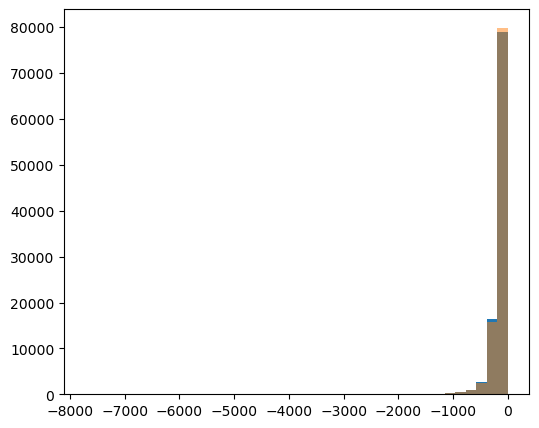

In [138]:
plt.rcParams["figure.figsize"] = (6,5)
plt.hist(log_probs, bins=40)
plt.hist(log_probs_offgrid, bins=40, alpha=0.5)


In [85]:
#Non-CE channel
mchirps = np.random.rand(no_samples)*100.
qs=np.random.rand(no_samples)
chieffs = (np.random.rand(no_samples)-0.5)*2.
zs = np.random.rand(no_samples)*10.

samples = np.dstack((mchirps,qs,chieffs,zs)) 
samples= np.reshape(samples,(no_samples,1,4))
log_probs = weighted_flow(samples, [0.0])
log_probs_offgrid = weighted_flow(samples, [0.15])

(array([2.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00,
        1.0000e+00, 1.0000e+00, 2.0000e+00, 1.0000e+00, 4.0000e+00,
        4.0000e+00, 2.0000e+00, 6.0000e+00, 4.0000e+00, 5.0000e+00,
        7.0000e+00, 7.0000e+00, 1.2000e+01, 1.5000e+01, 3.8000e+01,
        2.6000e+01, 4.1000e+01, 5.3000e+01, 7.9000e+01, 8.7000e+01,
        1.2200e+02, 1.7200e+02, 2.0800e+02, 3.1600e+02, 4.7700e+02,
        7.0800e+02, 1.0720e+03, 1.7640e+03, 2.8710e+03, 4.6240e+03,
        7.8340e+03, 1.3362e+04, 2.0792e+04, 2.3650e+04, 2.1628e+04]),
 array([-7.72492493e+02, -7.53164529e+02, -7.33836565e+02, -7.14508601e+02,
        -6.95180637e+02, -6.75852673e+02, -6.56524709e+02, -6.37196745e+02,
        -6.17868781e+02, -5.98540817e+02, -5.79212853e+02, -5.59884889e+02,
        -5.40556925e+02, -5.21228961e+02, -5.01900997e+02, -4.82573033e+02,
        -4.63245069e+02, -4.43917105e+02, -4.24589141e+02, -4.05261177e+02,
        -3.85933213e+02, -3.66605249e+02, -3.47277285e+02, -3.27949322e+02

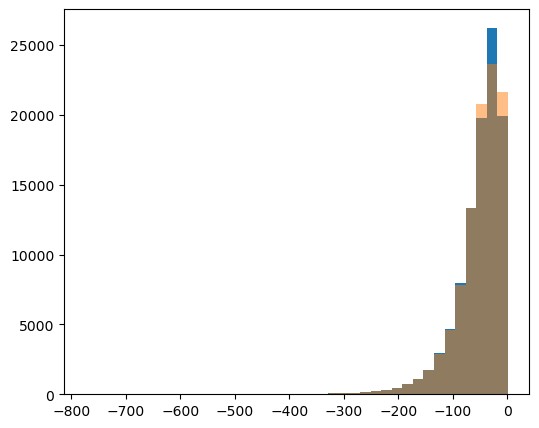

In [86]:
plt.rcParams["figure.figsize"] = (6,5)
plt.hist(log_probs, bins=40)
plt.hist(log_probs_offgrid, bins=40, alpha=0.5)

## Sampling from the Latent Space

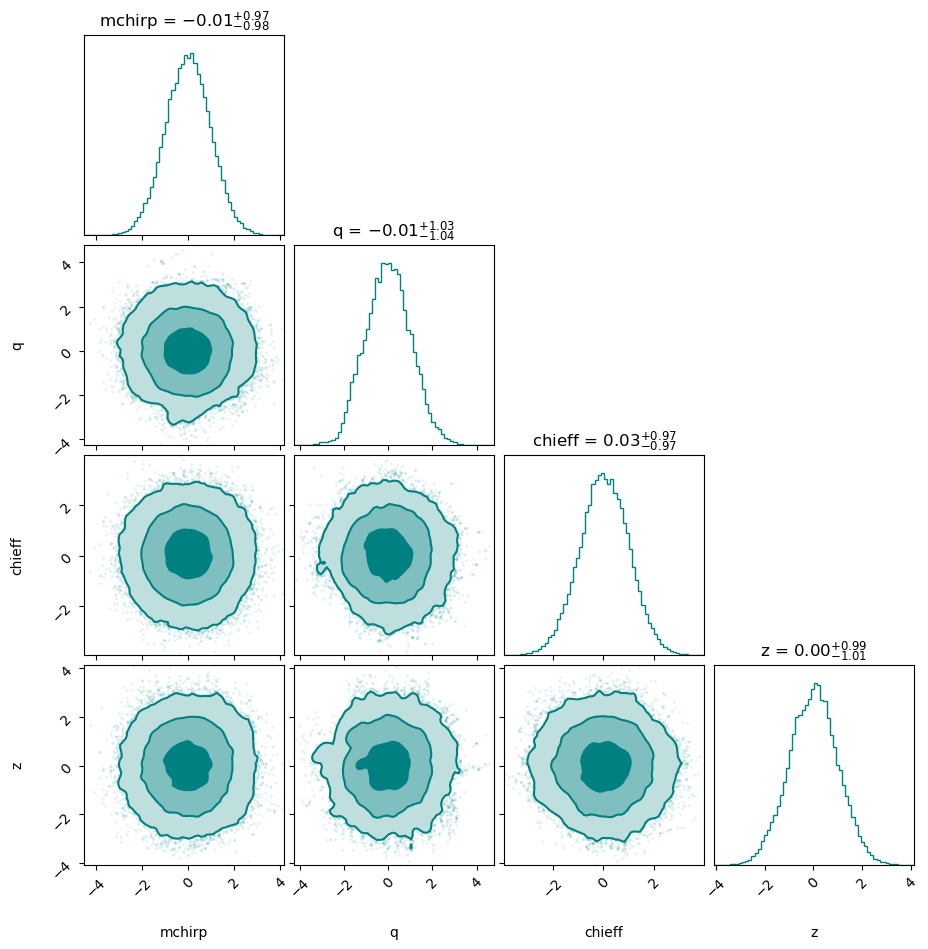

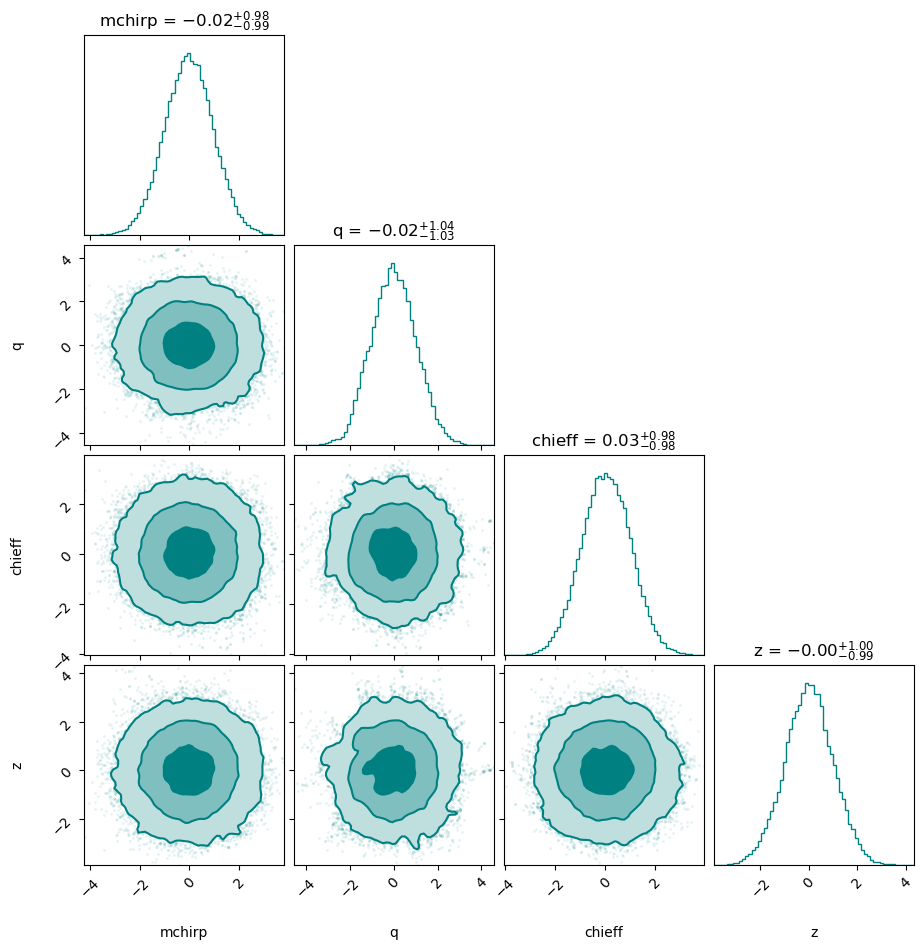

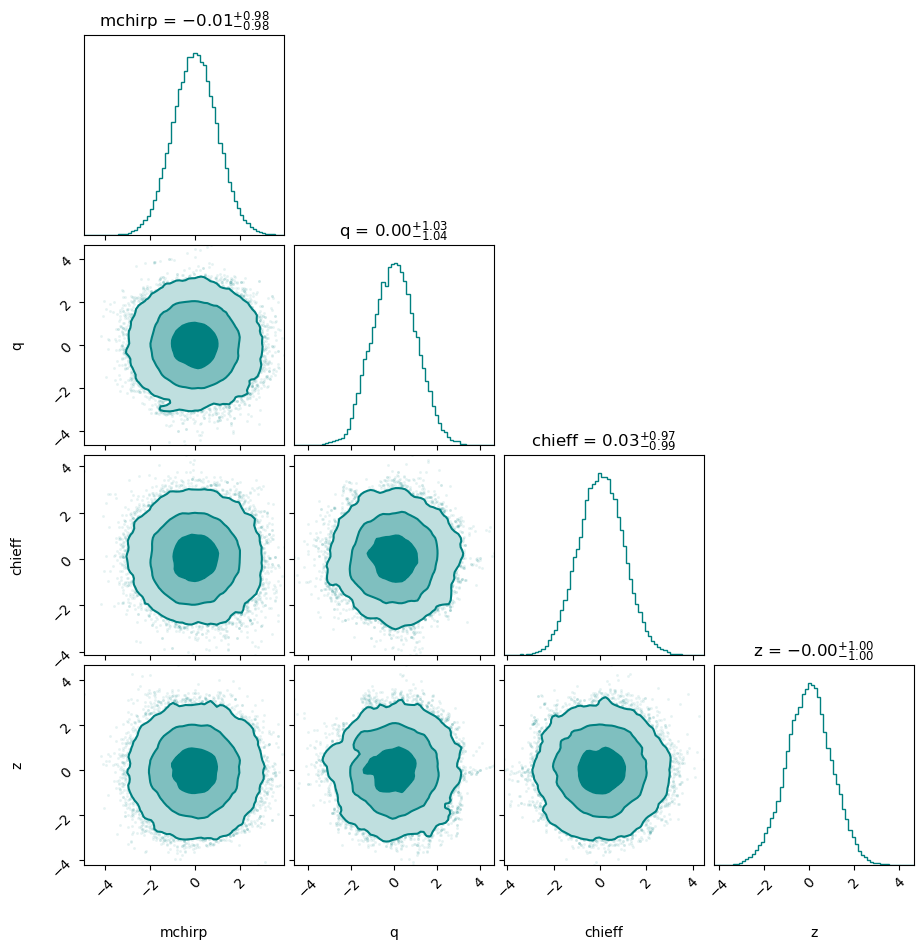

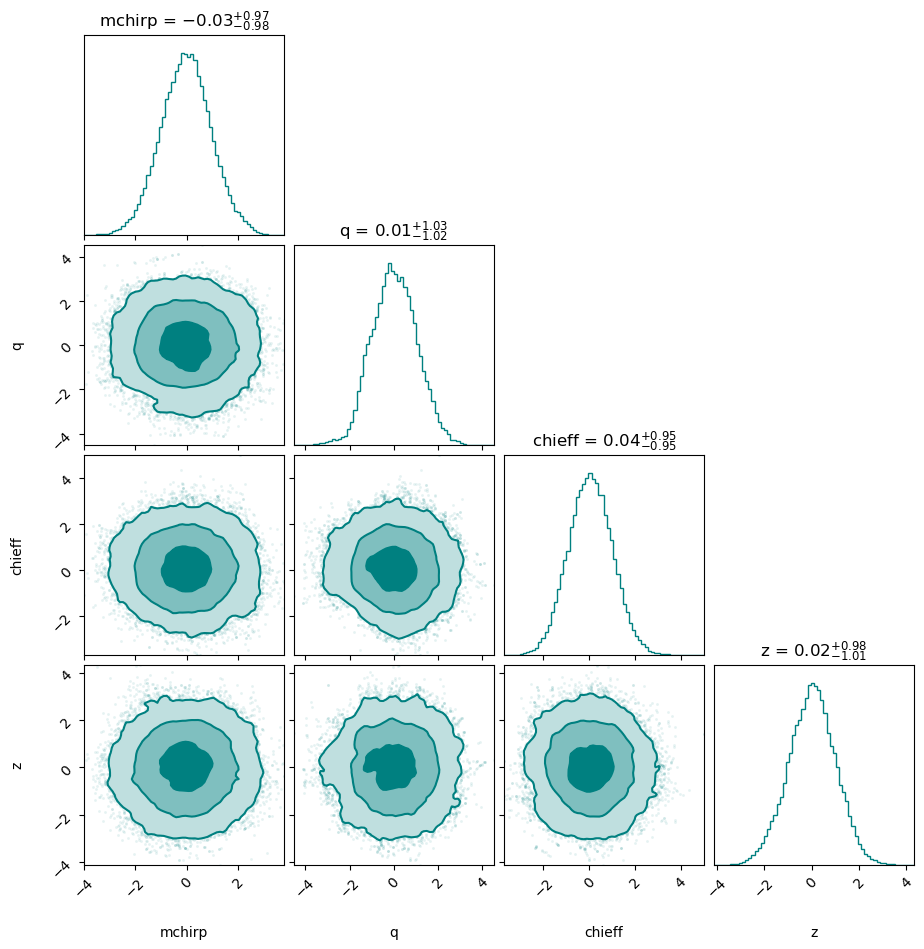

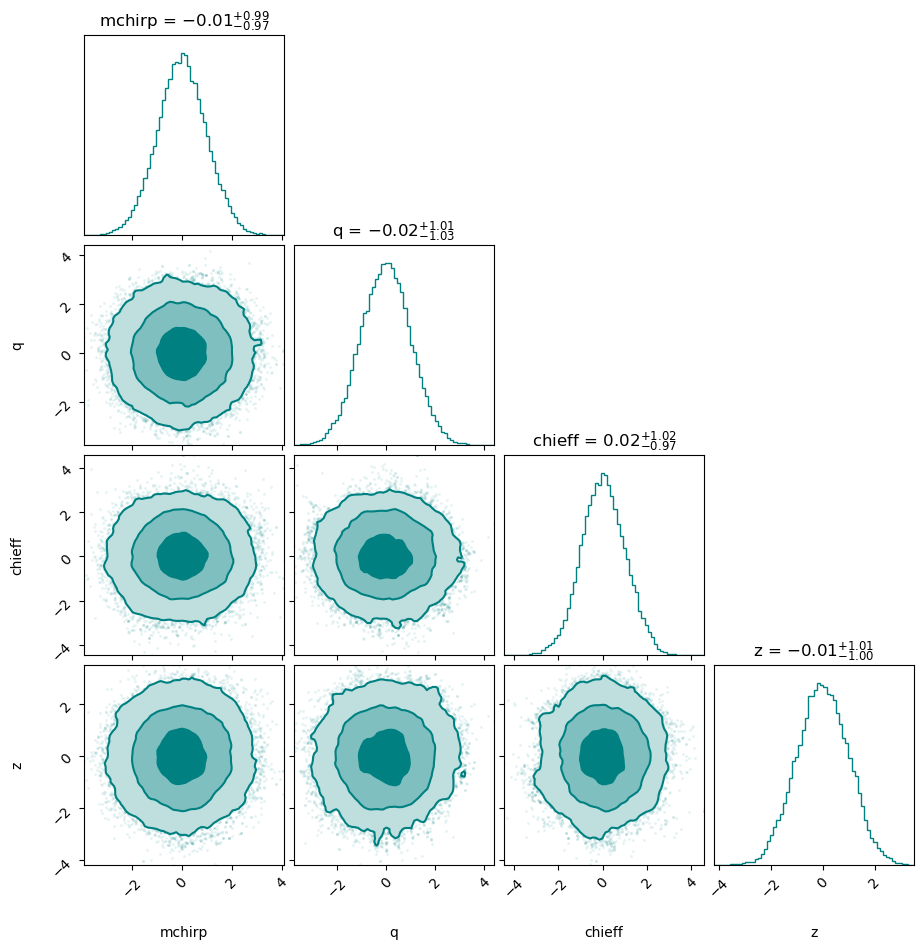

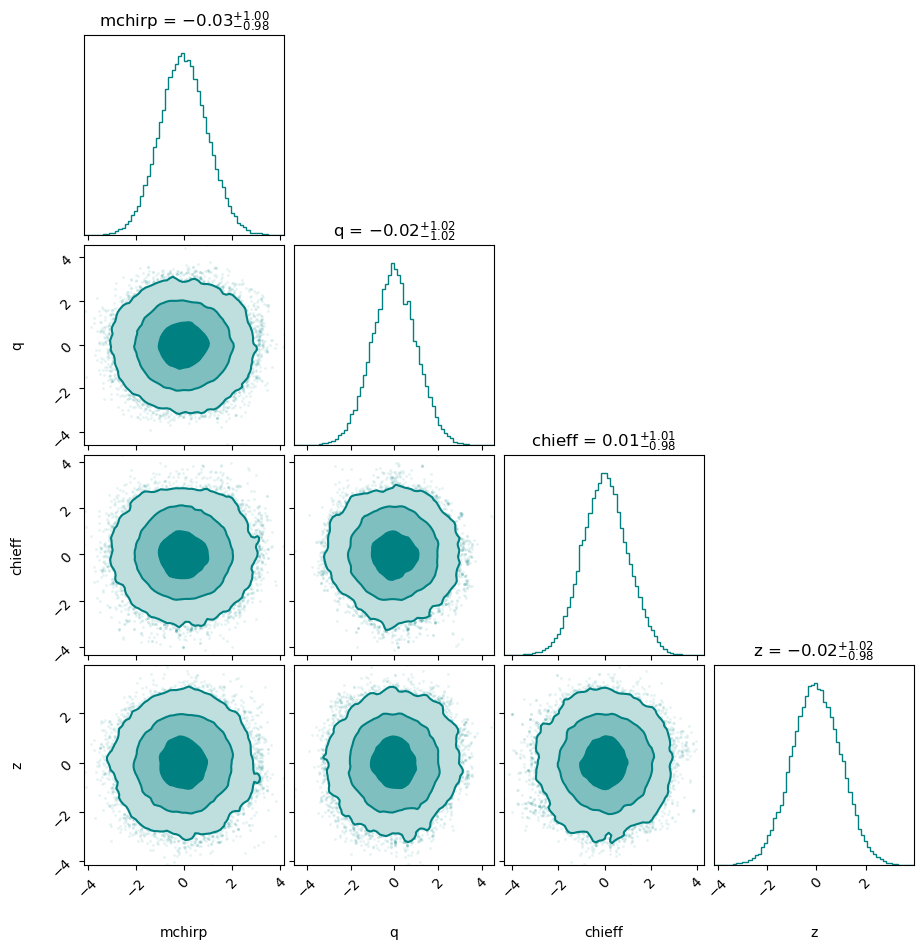

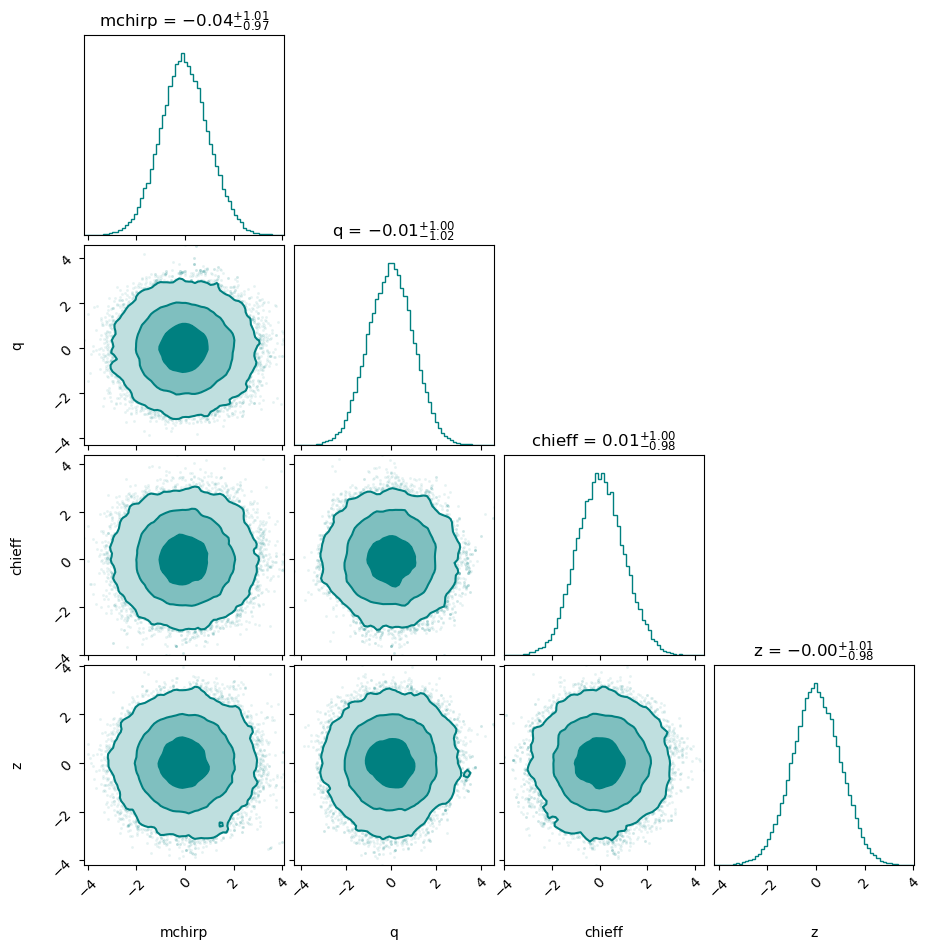

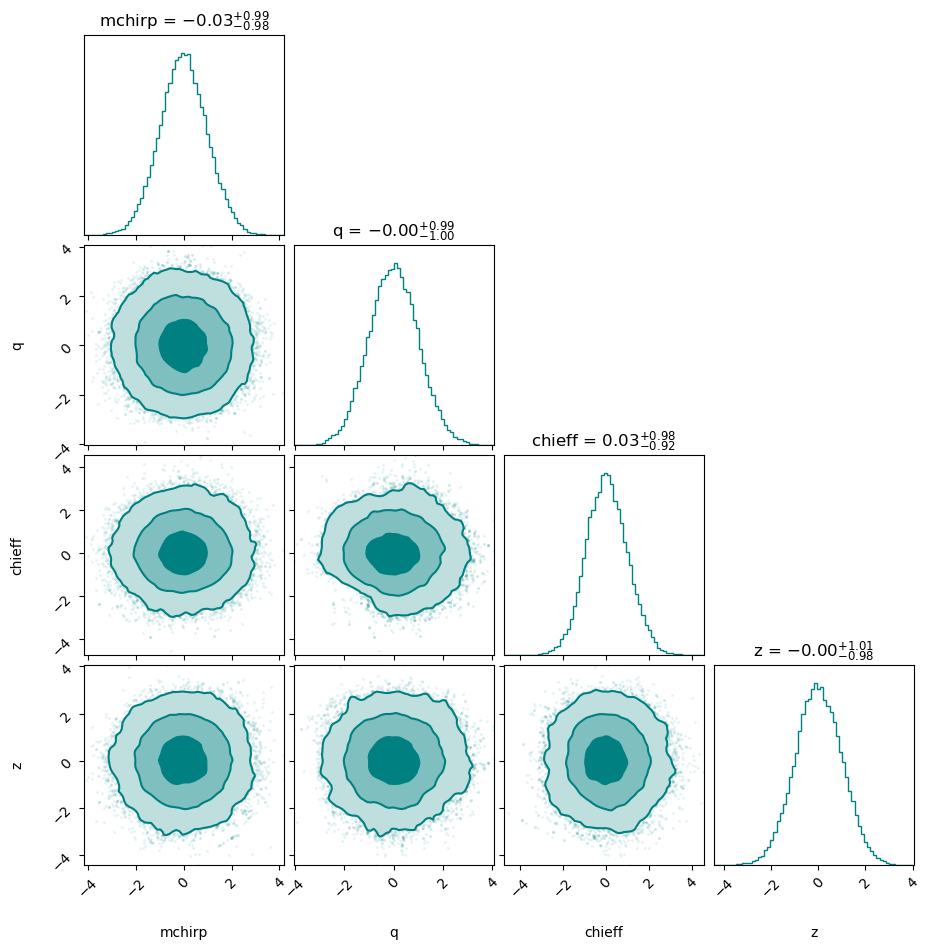

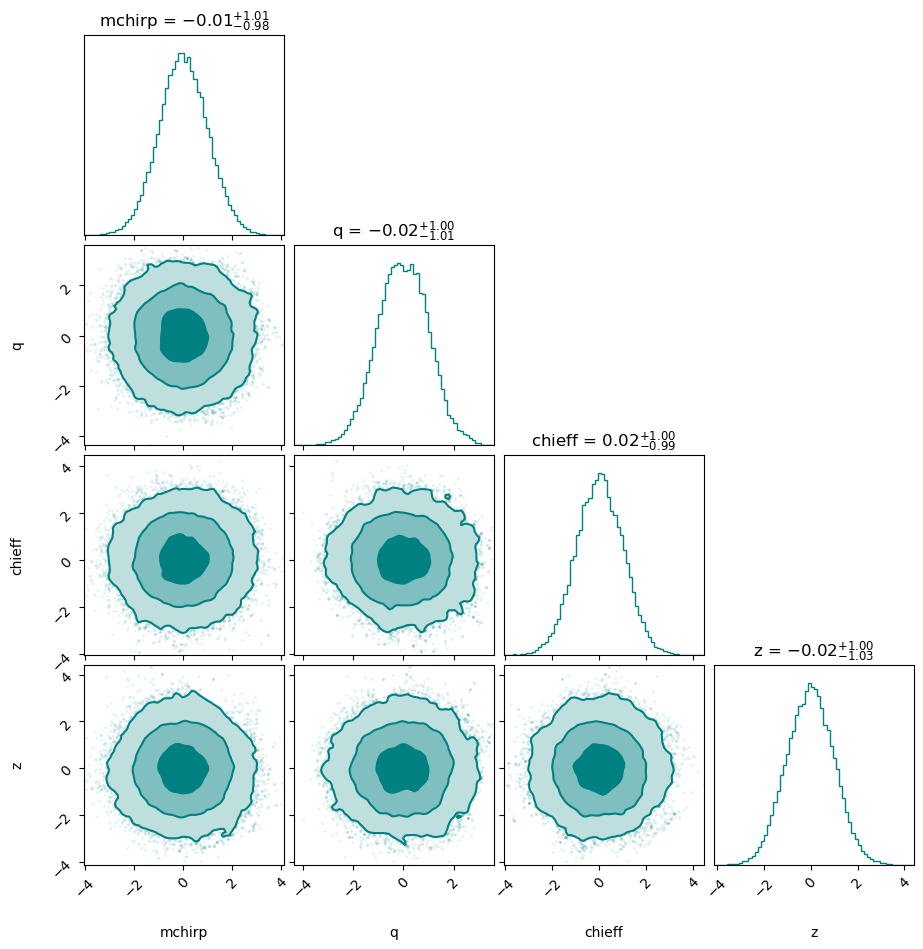

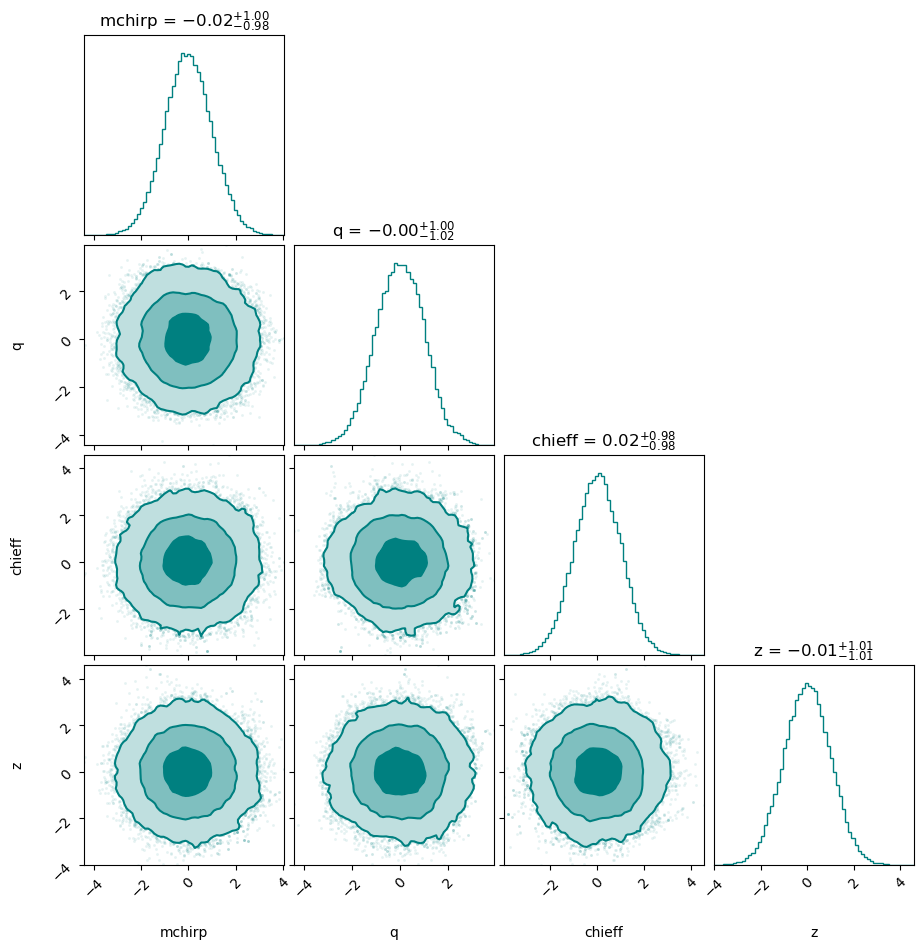

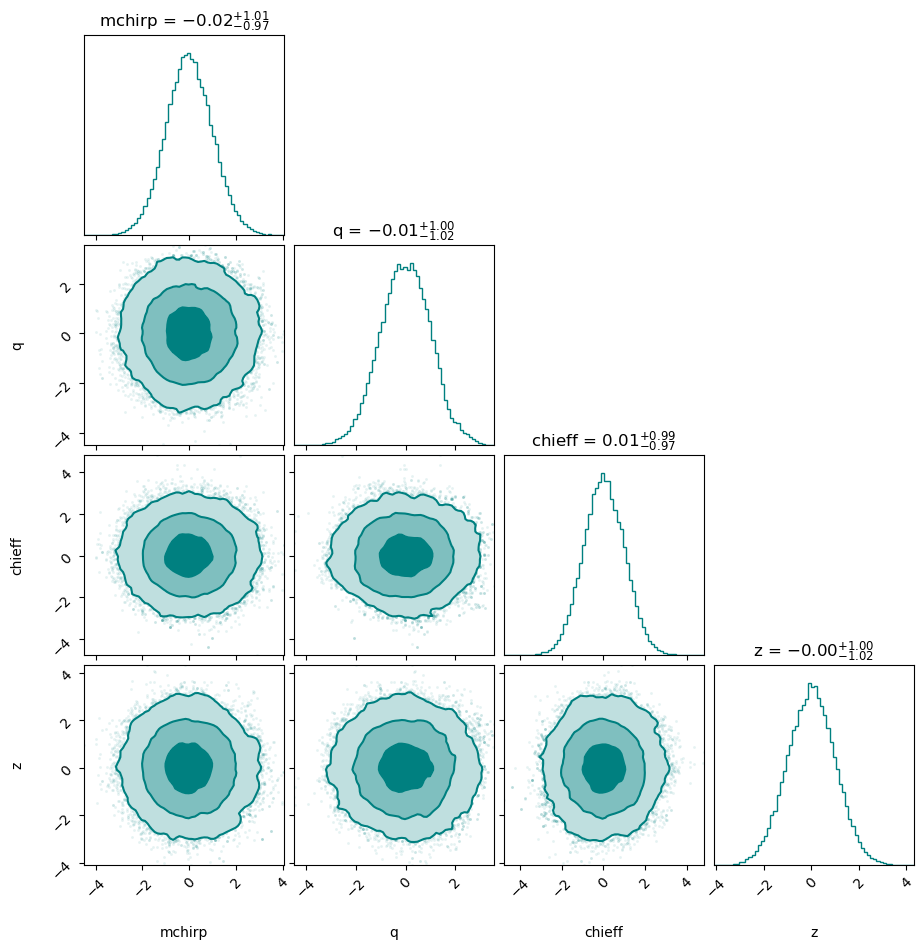

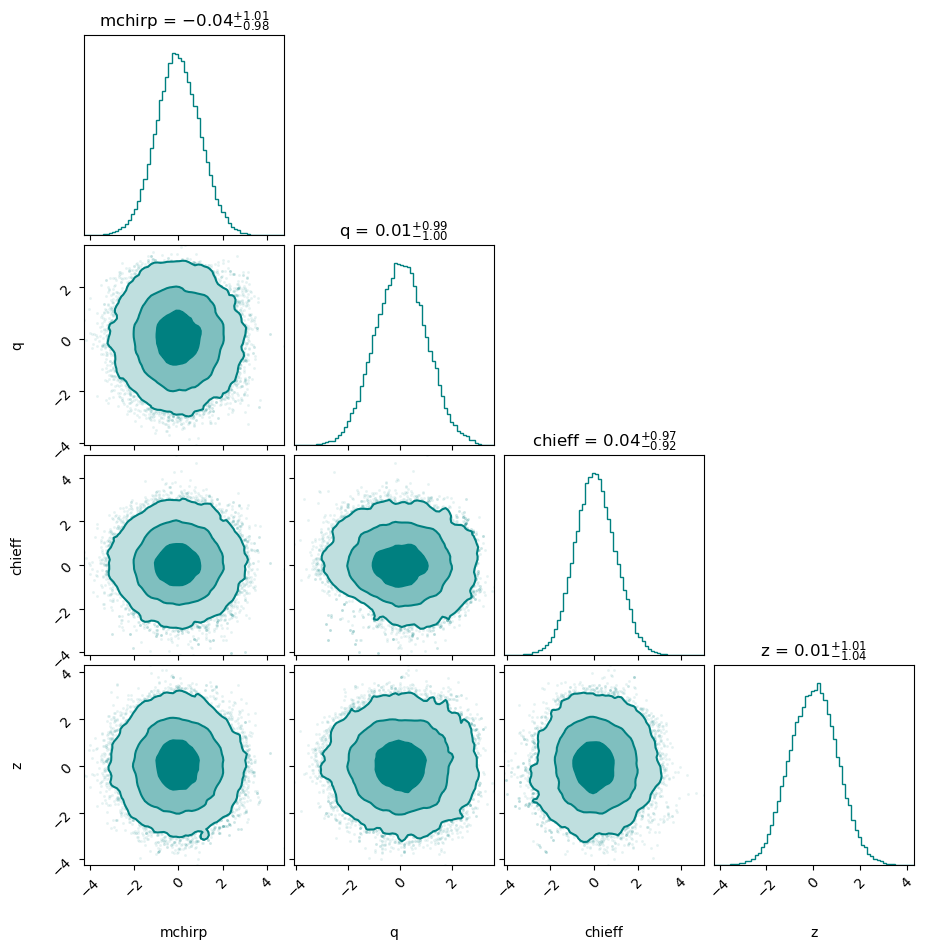

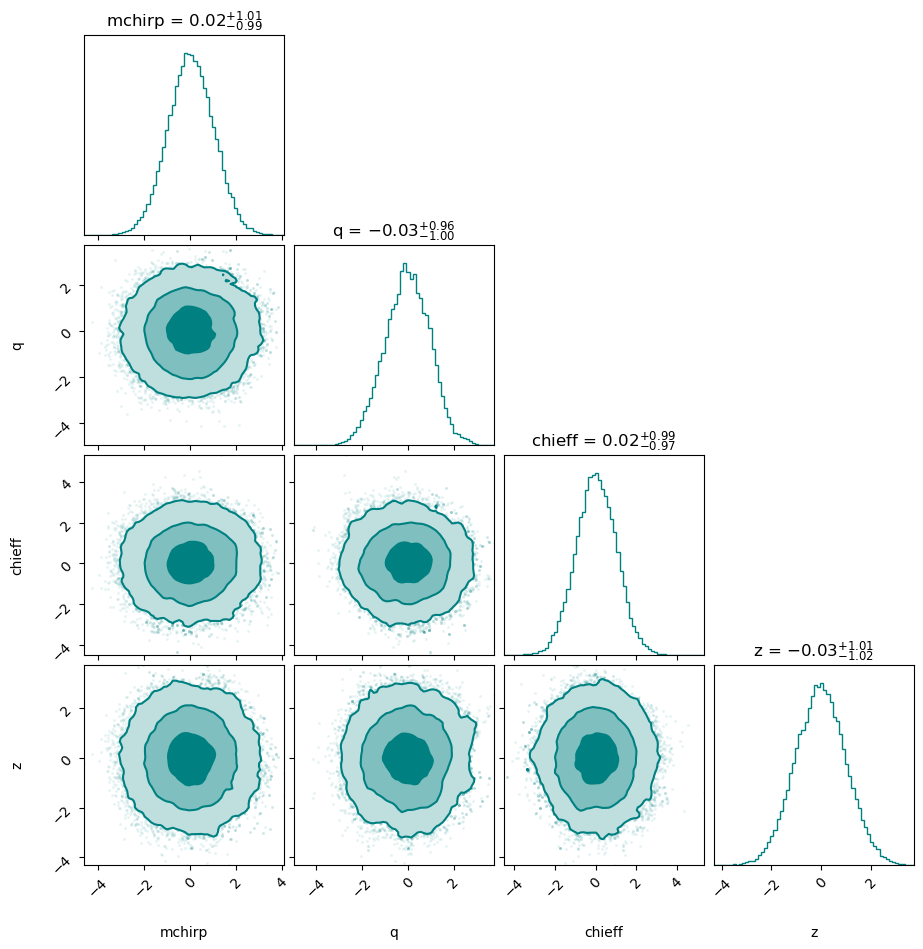

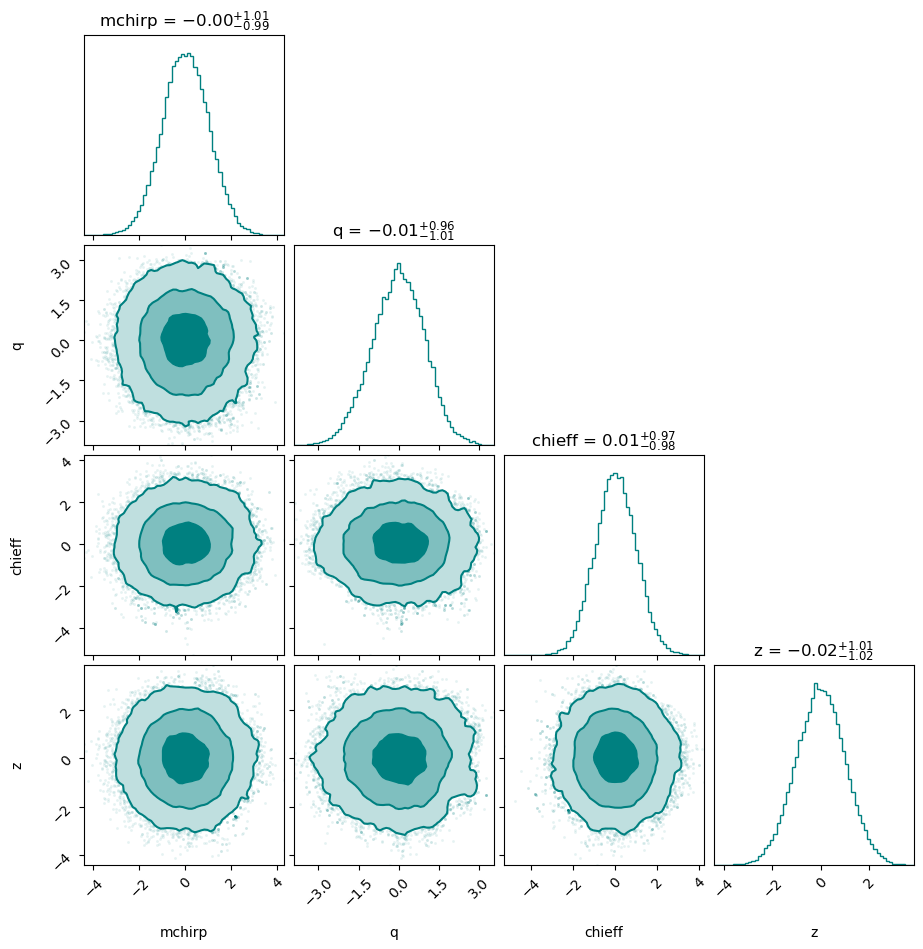

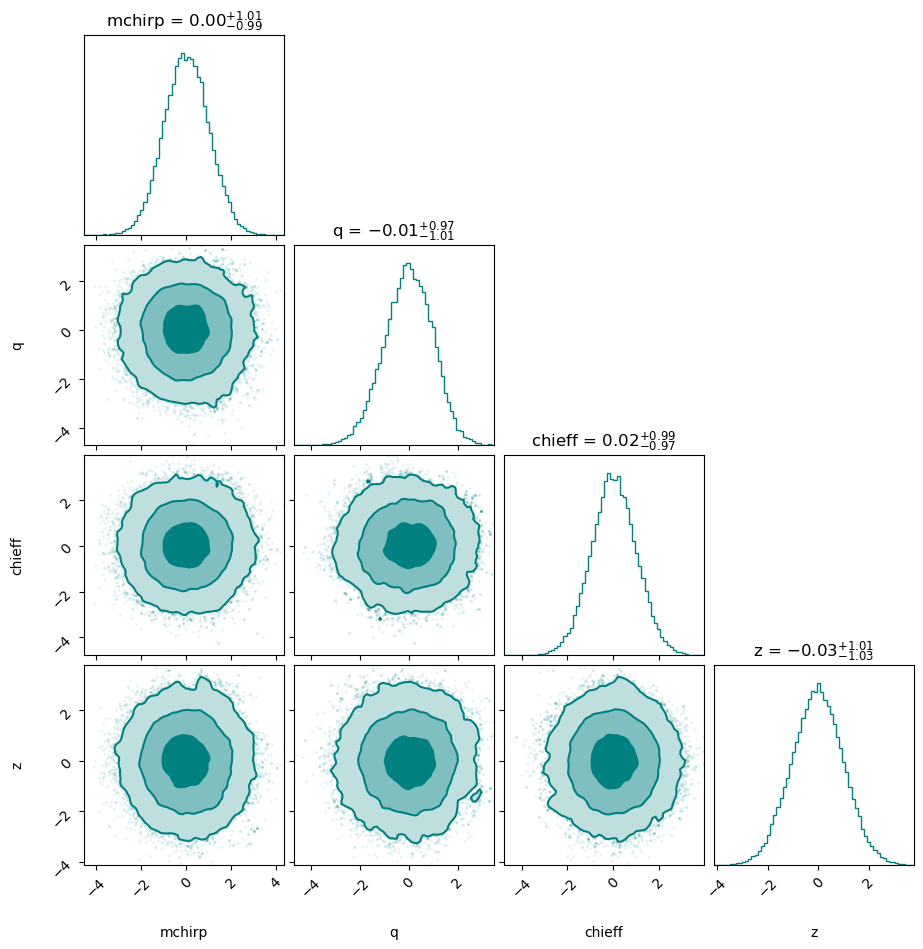

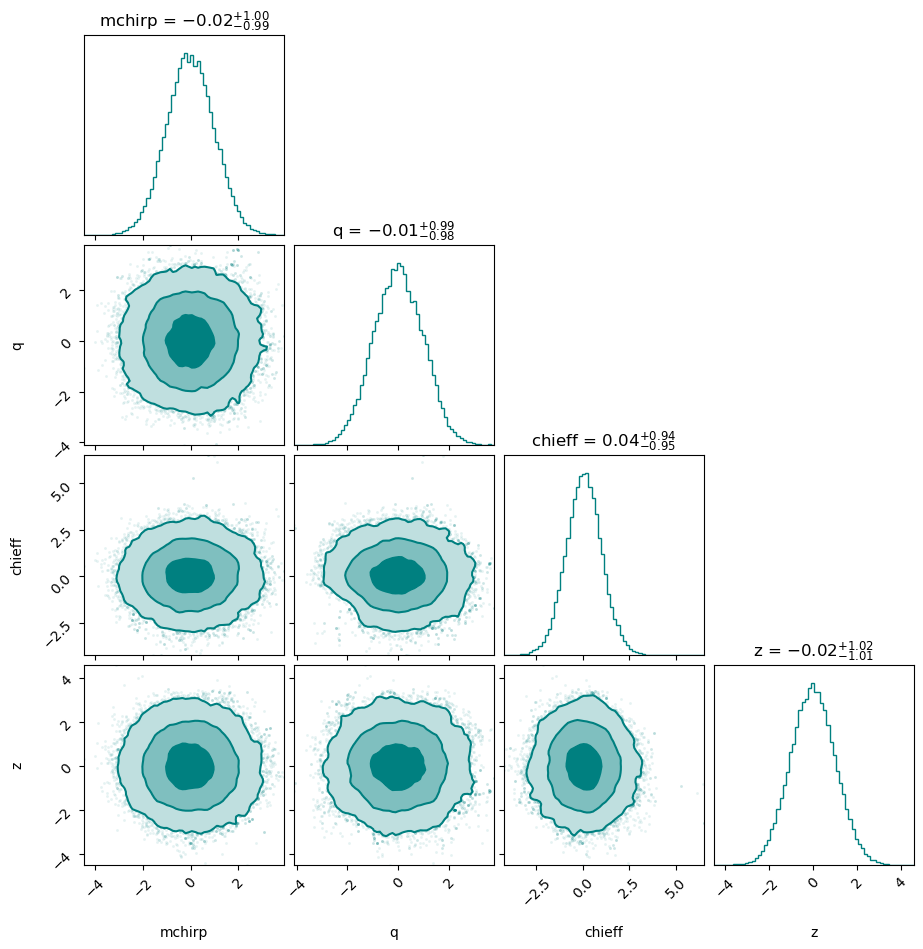

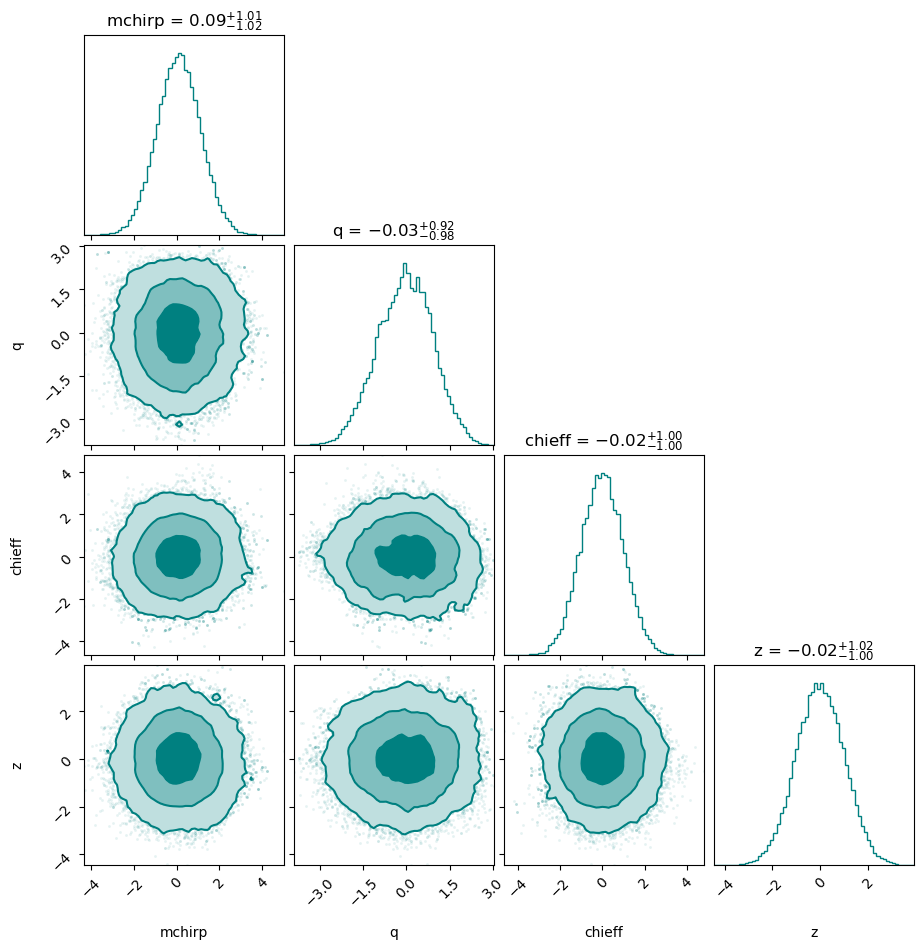

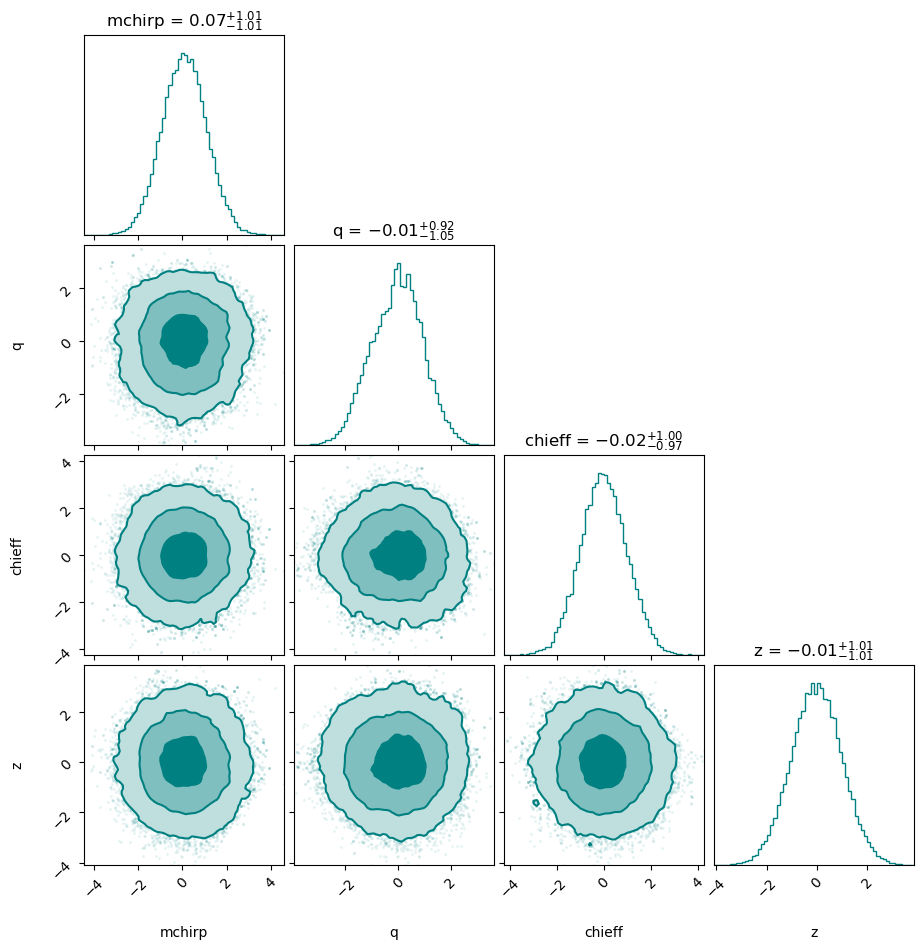

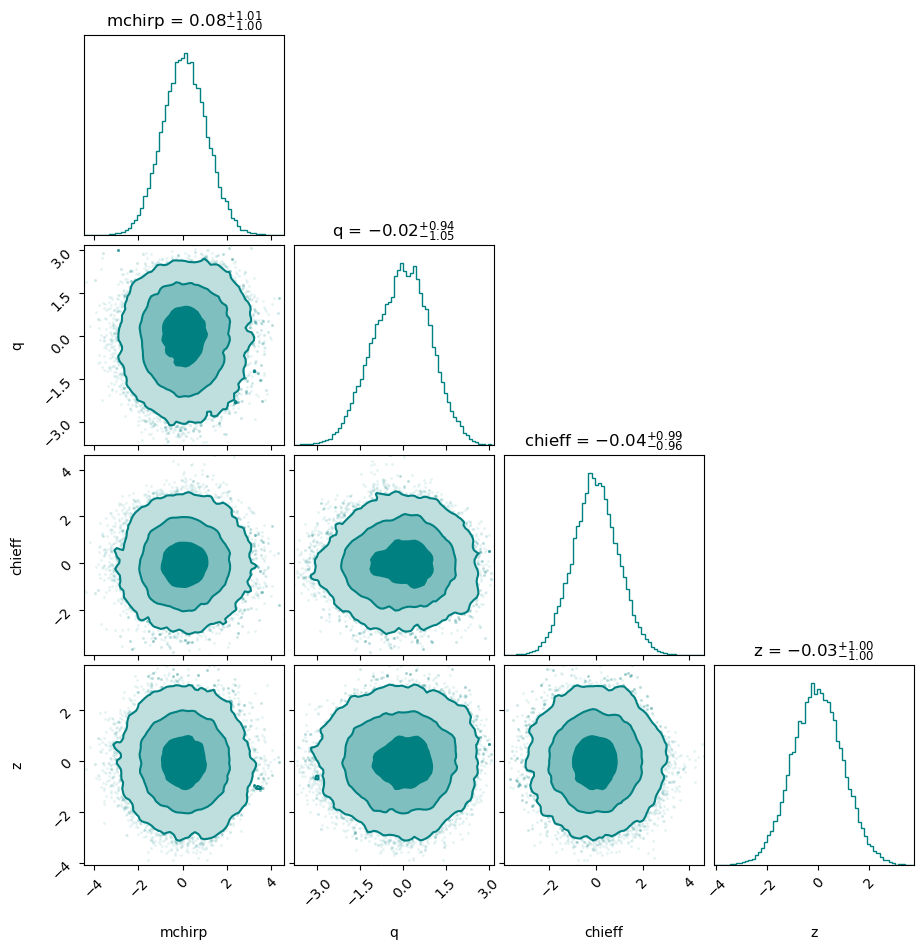

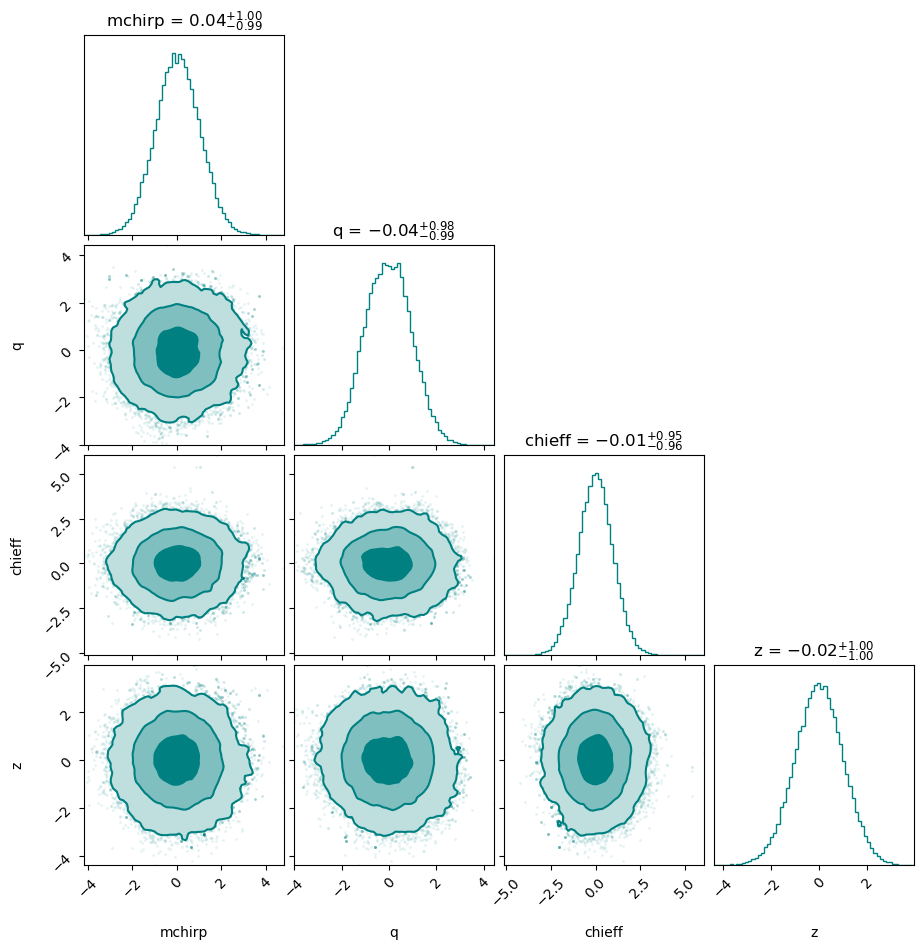

In [155]:
#CE, returns samples in the latent space of the flow

for alpha in range(5):
    for chib in range(4):
        cond_id = [chib,alpha]
        training_samps=np.reshape(np.array(models_dict[cond_id[0],cond_id[1]]), (-1,1,4))
        latent_samps = weighted_flow.get_latent_samps(training_samps[:no_samples,:], [chi_b[cond_id[0]], alpha_CE[cond_id[1]]]).detach().numpy()


        random_samples = np.random.choice(np.shape(training_samps)[0], size=(no_samples), p=weights_dict[cond_id[0],cond_id[1]]/np.sum(weights_dict[cond_id[0],cond_id[1]]))
        training_samps = np.reshape(np.array(models_dict[cond_id[0],cond_id[1]])[random_samples], (-1,1,4))

        weighted_latent_samps = weighted_flow.get_latent_samps(training_samps, [chi_b[cond_id[0]], alpha_CE[cond_id[1]]]).detach().numpy()
        corner.corner(weighted_latent_samps, **corner_kwargs)



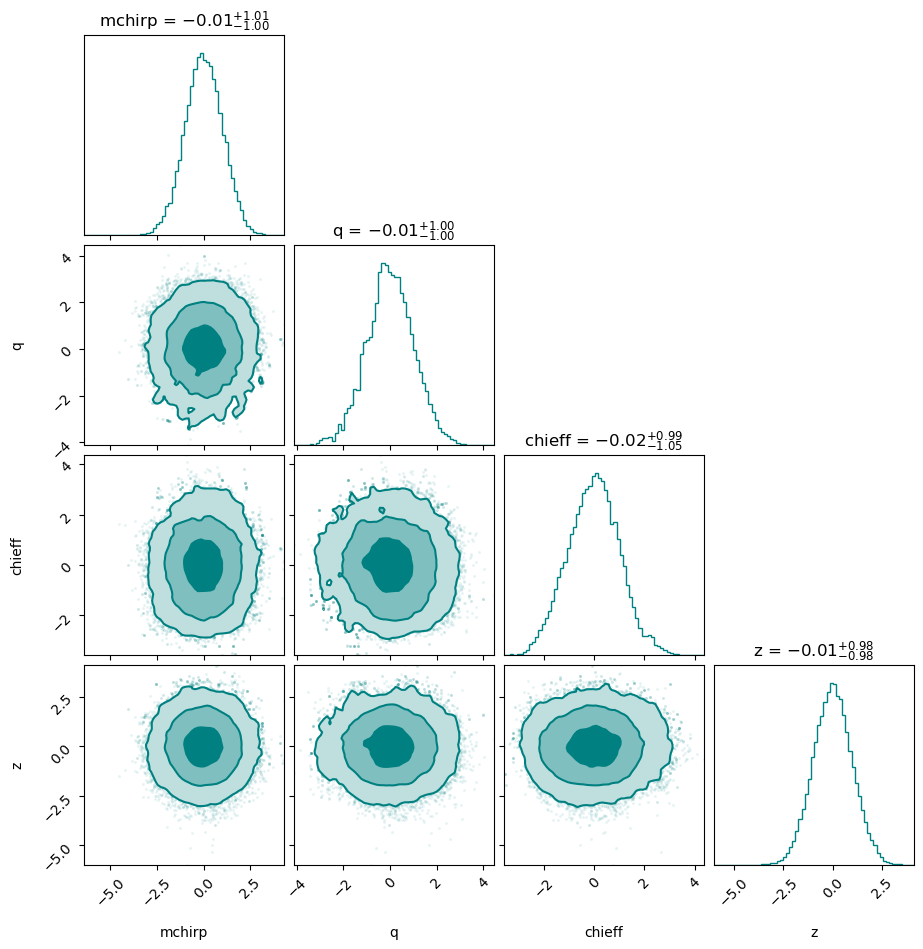

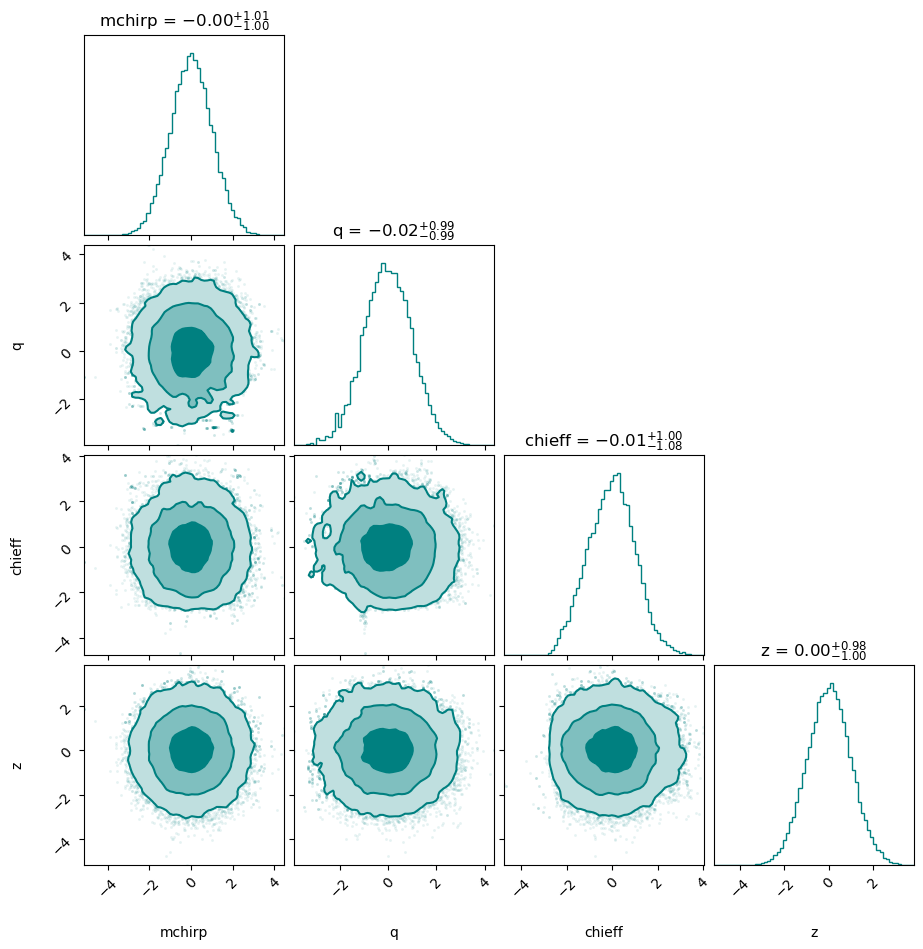

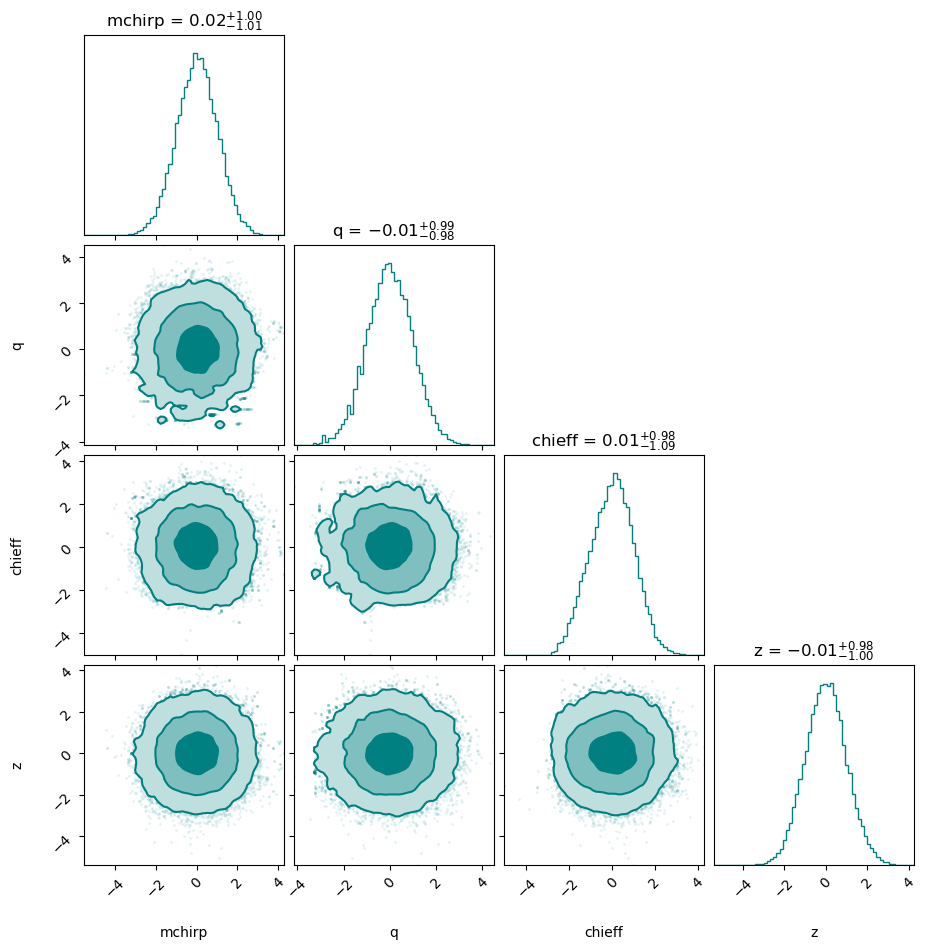

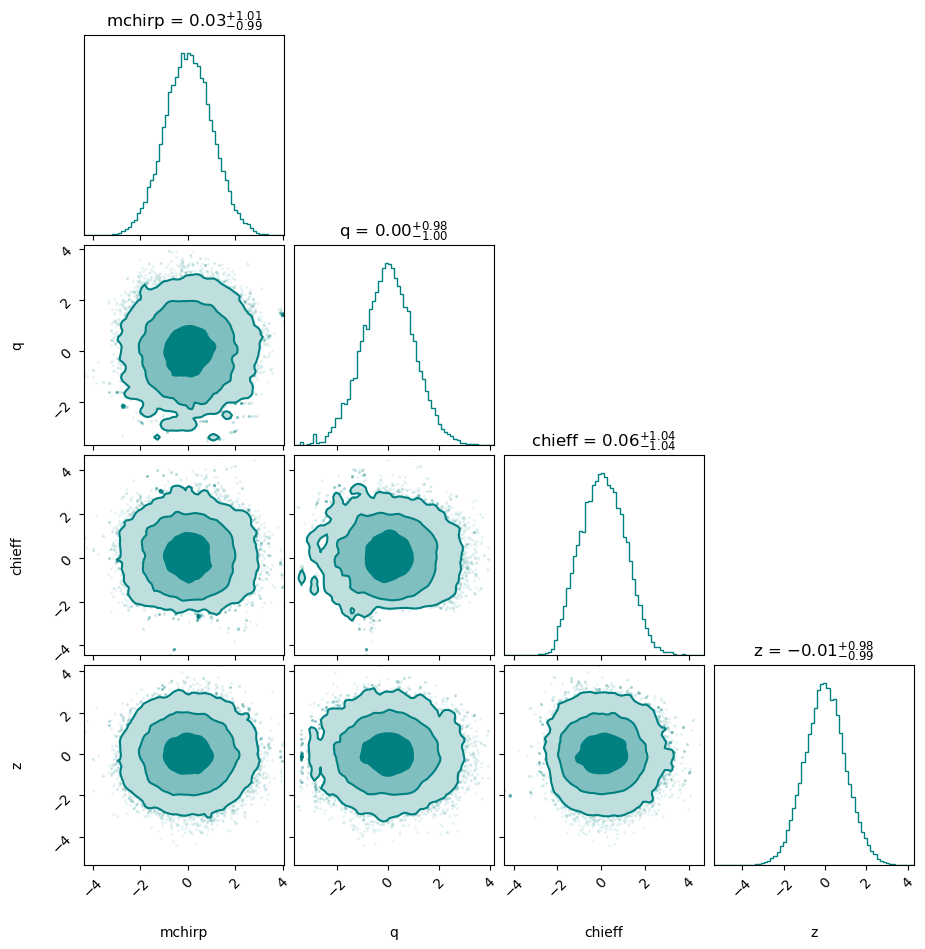

In [128]:
#Non-CE, returns samples in the latent space of the flow
#latent_samps = weighted_flow.get_latent_samps(samples, [0.1, 1.]).detach().numpy()

#non-weighted samples

for chibid, xb in enumerate(chi_b):
    training_samps=np.reshape(np.array(models_dict[chibid]), (-1,1,4))
    latent_samps = weighted_flow.get_latent_samps(training_samps[:no_samples,:], [xb]).detach().numpy()

    random_samples = np.random.choice(np.shape(training_samps)[0], size=(no_samples), p=weights_dict[chibid]/np.sum(weights_dict[chibid]))
    weighted_training_samps = np.reshape(np.array(models_dict[chibid])[random_samples], (-1,1,4))

    weighted_latent_samps = weighted_flow.get_latent_samps(weighted_training_samps, [xb]).detach().numpy()
    fig = corner.corner(weighted_latent_samps, **corner_kwargs)


## Drawing random samples from Gaussian and moving this through transforms

In [6]:
gaussian_samps = np.random.normal(loc=0., scale=1., size=(no_samples,4))
conds = np.repeat(np.array([[0.1]]),no_samples, axis=0)

mapped_samps = weighted_flow.flow.network.inverse(torch.from_numpy(gaussian_samps.astype(np.float32)), conditional=torch.from_numpy(conds.astype(np.float32)))

mapped_samps = mapped_samps[0].detach().numpy()
mapped_samps[:,0] = weighted_flow.expistic(mapped_samps[:,0], weighted_flow.mappings[0], weighted_flow.mappings[1])
mapped_samps[:,1] = weighted_flow.expistic(mapped_samps[:,1], weighted_flow.mappings[2])
mapped_samps[:,2] = np.tanh(mapped_samps[:,2])
mapped_samps[:,3] = weighted_flow.expistic(mapped_samps[:,3], weighted_flow.mappings[4], weighted_flow.mappings[5])

NameError: name 'no_samples' is not defined

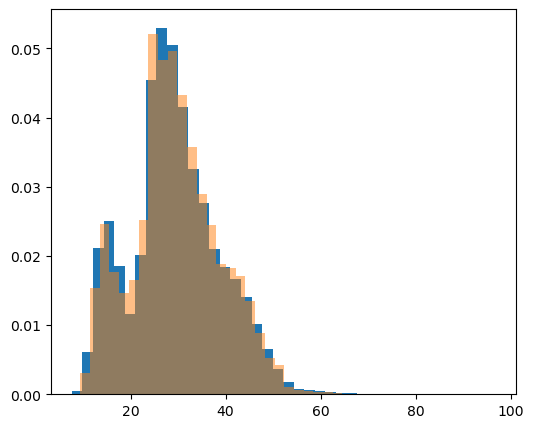

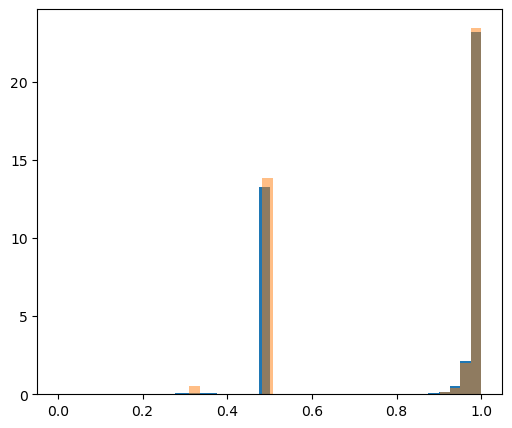

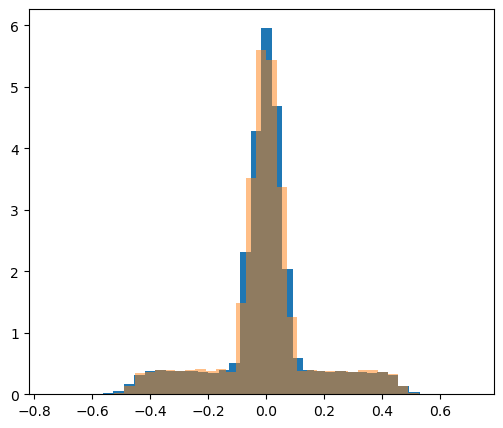

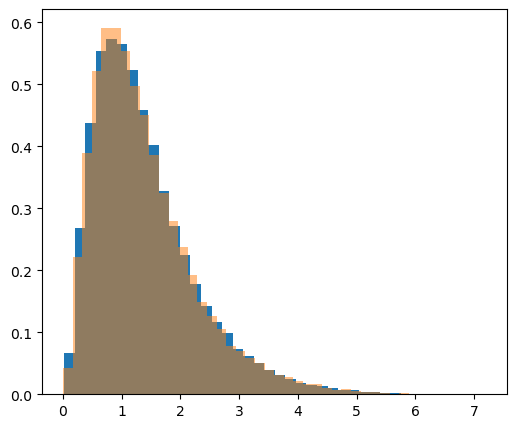

In [109]:
for i in range(no_params):
    fig, ax = plt.subplots((1))
    ax.hist(mapped_samps[:,i], bins=40, density=True)
    ax.hist(models_dict[1][:][param[i]], bins=40, density=True, weights=weights_dict[1], alpha=0.5)

In [75]:
corner_kwargs = dict(
    bins=64,
    smooth=0.9,
    color="teal",
    #quantiles=[0.16, 0.84],
    levels=(1 - np.exp(-0.5), 1 - np.exp(-2), 1 - np.exp(-9 / 2.0)),
    plot_density=True,
    plot_datapoints=True,
    fill_contours=True,
    show_titles=True,
    hist_kwargs=dict(density=True),
    labels=['mchirp','q','chieff','z'],
    axes_scale='log',
)
corner_kwargs_kde = dict(
    bins=64,
    smooth=0.9,
    color="purple",
    #quantiles=[0.16, 0.84],
    levels=(1 - np.exp(-0.5), 1 - np.exp(-2), 1 - np.exp(-9 / 2.0)),
    plot_density=True,
    plot_datapoints=True,
    fill_contours=True,
    show_titles=True,
    hist_kwargs=dict(density=True),
    labels=['mchirp','q','chieff','z'],
    axes_scale='log',
)

kwargs = deepcopy(corner_kwargs)
kwargs["color"] = "C1"
kwargs["hist_kwargs"]["color"] = "C1"

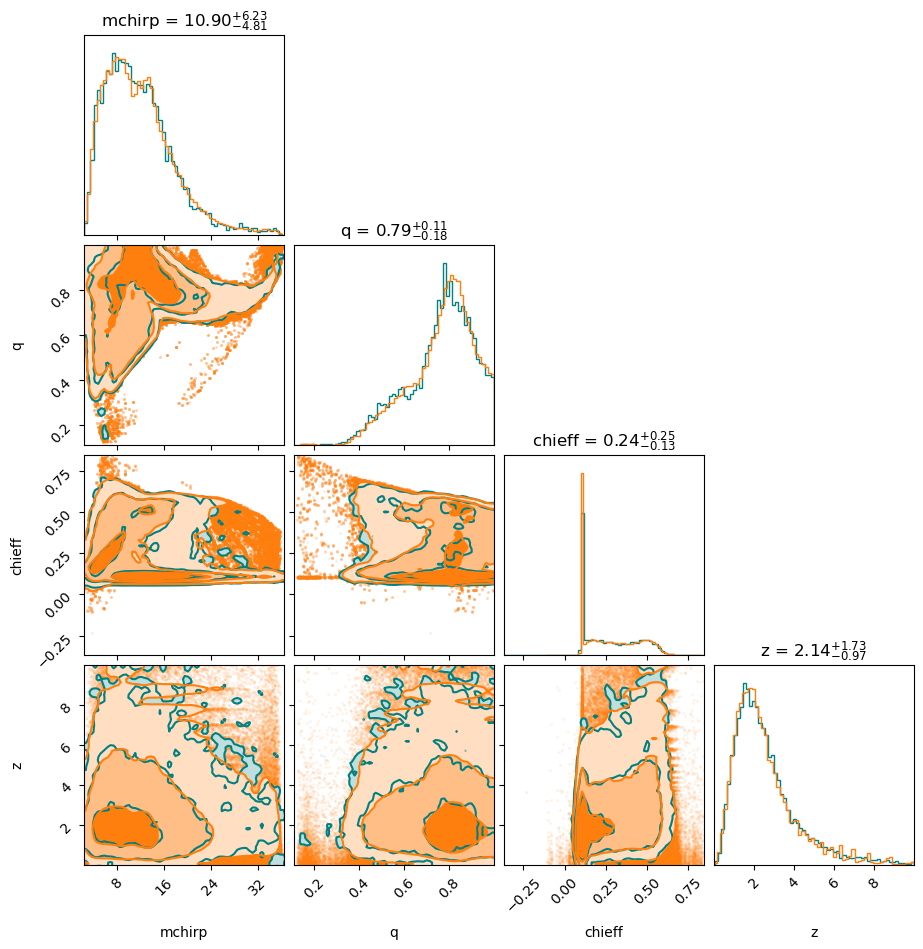

In [21]:
hyperparam_idxs = (1,2)

fig = corner.corner(mapped_samps, **corner_kwargs)
fig =corner.corner(models_dict[hyperparam_idxs], fig=fig, weights=weights_dict[hyperparam_idxs][:], **kwargs)

In [15]:
def move_around_data_and_cond(channel, cond_a, cond_b, data, n_steps):
    """
    Takes two locations in the conditional EOS space and a fixed 
    mass-lambda sample. Function takes n_steps between point_a 
    and point_b and passes each condition to the flow alongwith 
    the fixed mass-lambda sample. Returns #n_steps log probs. 0
    """
    if channel == 'CE':
        n_conds = 2
    else:
        n_conds= 1

    cond_a = np.reshape(cond_a, (n_conds, 1)).T
    cond_b = np.reshape(cond_b, (n_conds, 1)).T
    # empty array to fill with log probs
    steps_logprobs = []
    steps_lnlikes = []
 
    # move between these
    steps = np.linspace(0,1,int(n_steps))
 
    for i in steps:

        cond_sample = (i * cond_a) + ((1-i) * cond_b)

 
        if i == 0:
            print('first condition', cond_sample)
        if i == 1:
            print('last condition', cond_sample)
 
        #print(np.shape(data))
        # pass noise-added sample to flow
        sample_step_logprob = weighted_flow[channel_label](data, cond_sample)
        sample_steps_lnlike = samp.lnlike(cond_sample[0], data, weighted_flow, submodels_dict, [channel_label], prior_pdf=p_theta, use_flows=True)

 
        steps_logprobs = np.append(steps_logprobs, sample_step_logprob)
        steps_lnlikes = np.append(steps_lnlikes, sample_steps_lnlike)

    return steps_logprobs, steps_lnlikes

In [7]:
#CE
_concentration = np.ones(len(channels))
gw_path = '/Users/stormcolloms/Documents/PhD/Project_work/AMAZE_model_selection/gw_events'
observations, obsdata, p_theta, events = gw_obs.generate_observations(param, gw_path, \
                                            100, 'posteriors', 'p_theta')

steps_logprobs,steps_lnlikes = move_around_data_and_cond(channel_label, np.array([0.2,4.]), np.array([0.,4.]), obsdata, 100)

NameError: name 'move_around_data_and_cond' is not defined

In [14]:
samp.lnlike(np.array([0.2,4.5]), obsdata, weighted_flow, submodels_dict, [channel_label], prior_pdf=p_theta, use_flows=True)


tensor([[0.2000, 4.5000],
        [0.2000, 4.5000],
        [0.2000, 4.5000],
        ...,
        [0.2000, 4.5000],
        [0.2000, 4.5000],
        [0.2000, 4.5000]])


104.56438970728549

In [8]:
#Non_CE

steps_logprobs, steps_lnlikes = move_around_data_and_cond(channel_label, np.array([0.1]), np.array([0.]), obsdata, 100)

first condition [[0.]]
[0.0, 1.0]
[0.0010101010101010103, 1.0]
[0.0020202020202020206, 1.0]
[0.0030303030303030307, 1.0]
[0.004040404040404041, 1.0]
[0.005050505050505052, 1.0]
[0.0060606060606060615, 1.0]
[0.007070707070707072, 1.0]
[0.008080808080808083, 1.0]
[0.009090909090909092, 1.0]
[0.010101010101010104, 1.0]
[0.011111111111111113, 1.0]
[0.012121212121212123, 1.0]
[0.013131313131313133, 1.0]
[0.014141414141414144, 1.0]
[0.015151515151515152, 1.0]
[0.016161616161616165, 1.0]
[0.017171717171717175, 1.0]
[0.018181818181818184, 1.0]
[0.019191919191919194, 1.0]
[0.020202020202020207, 1.0]
[0.021212121212121213, 1.0]
[0.022222222222222227, 1.0]
[0.023232323232323236, 1.0]
[0.024242424242424246, 1.0]
[0.025252525252525256, 1.0]
[0.026262626262626265, 1.0]
[0.02727272727272728, 1.0]
[0.028282828282828288, 1.0]
[0.029292929292929294, 1.0]
[0.030303030303030304, 1.0]
[0.031313131313131314, 1.0]
[0.03232323232323233, 1.0]
[0.03333333333333334, 1.0]
[0.03434343434343435, 1.0]
[0.03535353535

Text(0, 0.5, 'ln likelihood at alpha_CE=4.')

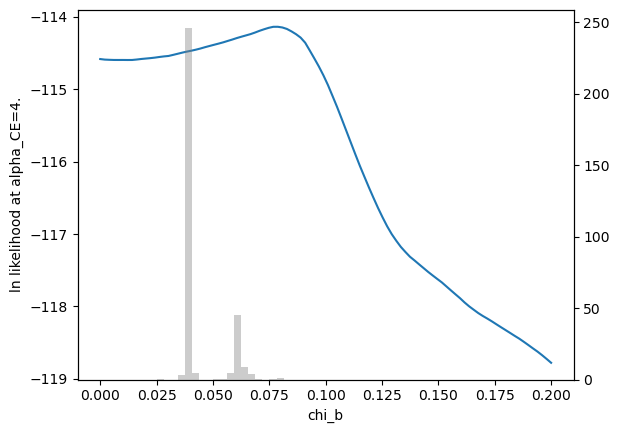

In [9]:
fig, ax =plt.subplots(1,1)

ax.plot(np.linspace(0.,0.2,int(100)),steps_lnlikes)
#ax.plot(np.linspace(0.7,2.4,int(100)),steps_lnprior)

secax = ax.twinx()
flow_filename = '/Users/stormcolloms/Documents/PhD/Project_work/AMAZE_model_selection/rns/Flows_190324_CEonlycontinuous/output.hdf5'
flow_file = h5py.File(flow_filename, 'r')

alpha_samps = list(flow_file['model_selection']['samples']['block0_values'][:,0])

secax.hist(alpha_samps, density=True, label='flow', color='grey', alpha=0.4, bins=20)
ax.set_xlabel('chi_b')
ax.set_ylabel('ln likelihood at alpha_CE=4.')
#secax.set_ylabel('inference alhpa')

In [10]:
#CE
np.random.seed(8675309)
_concentration = np.ones(len(channels))
gw_path = '/Users/stormcolloms/Documents/PhD/Project_work/AMAZE_model_selection/gw_events'
observations, obsdata, p_theta, events = gw_obs.generate_observations(param, gw_path, \
                                            100, 'posteriors', 'p_theta')

steps_logprobs,steps_lnlikes = move_around_data_and_cond(channel_label, np.array([0.03818,4.999]), np.array([0.03818,0.201]), obsdata, 100)

NameError: name 'move_around_data_and_cond' is not defined

In [18]:
import scipy as sp
alpha_grid = np.reshape(tuple(weighted_flow['CE'].alpha.values()), (len(weighted_flow['CE'].hps[0]),len(weighted_flow['CE'].hps[1])))
alpha_interp = sp.interpolate.RegularGridInterpolator((weighted_flow['CE'].hps[0],weighted_flow['CE'].hps[1]), alpha_grid, fill_value=None)
alpha = alpha_interp([[np.array([0.0, 0.5])]])

In [19]:
alpha

array([[0.00103017]])

In [21]:
np.reshape(tuple(weighted_flow['CE'].alpha.values()), (len(weighted_flow['CE'].hps[0]),len(weighted_flow['CE'].hps[1])))

array([[0.0092669 , 0.00103017, 0.00200405, 0.00107388, 0.0006299 ],
       [0.00979066, 0.00107582, 0.00212311, 0.00111036, 0.00069527],
       [0.01039166, 0.00119312, 0.00223543, 0.00120761, 0.00070632],
       [0.01272628, 0.00143119, 0.00281134, 0.00139999, 0.00080779]])

Text(0, 0.5, 'ln likelihood at chi_b=0.03818')

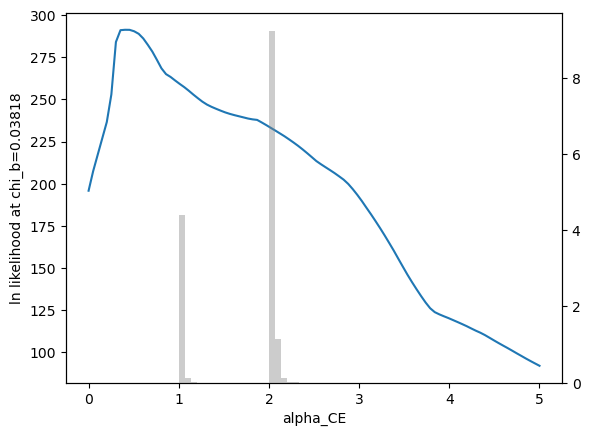

In [19]:
fig, ax =plt.subplots(1,1)

ax.plot(np.linspace(0.,5.,int(100)), steps_lnlikes)
#ax.plot(np.linspace(0.7,2.4,int(100)),steps_lnprior)

secax = ax.twinx()
flow_filename = '/Users/stormcolloms/Documents/PhD/Project_work/AMAZE_model_selection/rns/Flows_190324_CEonlycontinuous/output.hdf5'
flow_file = h5py.File(flow_filename, 'r')

alpha_samps = list(flow_file['model_selection']['samples']['block0_values'][:,1])

secax.hist(alpha_samps, density=True, label='flow', color='grey', alpha=0.4, bins=20)
ax.set_xlabel('alpha_CE')
ax.set_ylabel('ln likelihood at chi_b=0.03818')
#secax.set_ylabel('inference alhpa')

In [11]:
#2D likelihood over chib alpha
grid_res=50
alphas = np.linspace(0.2,4.99999,50)
chibs = np.linspace(0.,0.499999,50)

p_chibalpha = np.zeros((50,50))

for chibid, xb in enumerate(chibs):
    for alphaid, a  in enumerate(alphas):
            p_chibalpha[chibid, alphaid] = samp.lnlike([xb,a], obsdata, weighted_flow, submodels_dict, channels, use_flows=True, prior_pdf=p_theta)

In [13]:
flow_filename = '/Users/stormcolloms/Documents/PhD/Project_work/AMAZE_model_selection/rns/Flows_190324_CEonlycontinuous/output.hdf5'
flow_file = h5py.File(flow_filename, 'r')

In [1]:
fig,ax = plt.subplots(1,1)
c = ax.imshow(np.swapaxes(p_chibalpha,0,1), extent=(0, 5, 0, 0.5), origin='lower', aspect='auto', zorder=-200)
corner.hist2d(np.array(flow_file['model_selection']['samples']['block0_values'][:,1]), np.array(flow_file['model_selection']['samples']['block0_values'][:,0]),\
             alpha=0.5, density=True, ax=ax, no_fill_contours=True, range=[(0,5.),(0.,.5)])

ax.set_xlabel('alpha_CE')
ax.set_ylabel('chi_b')
#plt.ylim(0,5.)


NameError: name 'plt' is not defined

Text(0, 0.5, 'chi_b')

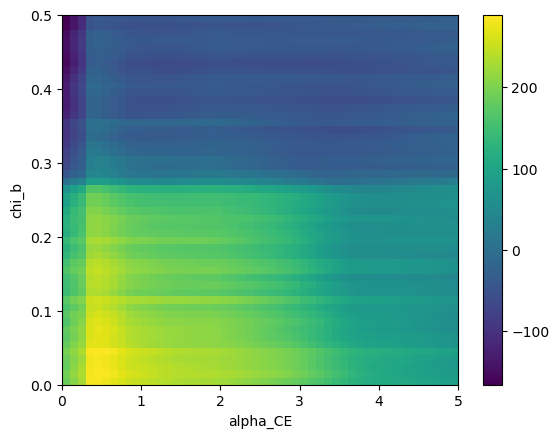

In [15]:
fig,ax = plt.subplots(1,1)
c = ax.imshow(p_chibalpha, extent=(0, 5, 0, 0.5), origin='lower', aspect='auto', zorder=-200)
cbar = fig.colorbar(c, ax=ax)

ax.set_xlabel('alpha_CE')
ax.set_ylabel('chi_b')
#plt.ylim(0,5.)


Text(0, 0.5, 'chi_b')

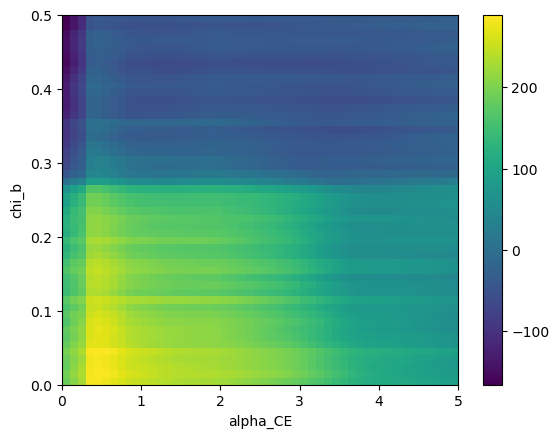

In [16]:
fig,ax = plt.subplots(1,1)
c = ax.imshow(p_chibalpha, extent=(0, 5, 0, 0.5), origin='lower', aspect='auto', zorder=-200)
cbar = fig.colorbar(c, ax=ax)

ax.set_xlabel('alpha_CE')
ax.set_ylabel('chi_b')
#plt.ylim(0,5.)